# Importer les librairies

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

%matplotlib inline
tf.__version__


'2.12.0'

In [2]:
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

tf.random.set_seed(3)
from tensorflow import keras
from tensorflow.math import confusion_matrix


# 1.Importer les donnees

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
image_size = (224, 224)
batch_size = 16
# ajouter plus de races
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dog',
    labels="inferred",
    label_mode="int",
    class_names=None,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 589 files belonging to 3 classes.
Using 472 files for training.
Using 117 files for validation.


In [5]:
data_iterator = train_ds.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
batch[0].shape

(16, 224, 224, 3)

In [8]:
batch[0]

array([[[[ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         ...,
         [ 21.662947 ,  22.662947 ,  17.662947 ],
         [ 21.325893 ,  22.325893 ,  17.325893 ],
         [ 21.325893 ,  22.325893 ,  17.325893 ]],

        [[ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         ...,
         [ 20.       ,  21.       ,  16.       ],
         [ 20.011162 ,  21.011162 ,  16.011162 ],
         [ 20.011162 ,  21.011162 ,  16.011162 ]],

        [[ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         [ 85.       ,  85.       ,  77.       ],
         ...,
         [ 20.685268 ,  21.685268 ,  16.685268 ],
         [ 21.685268 ,  22.685268 ,  17.685268 ],
         [ 21.685268 ,  22.685268 ,  17.685268 ]],

        ...,

        [[ 91.91559  ,  95.91559  ,  9

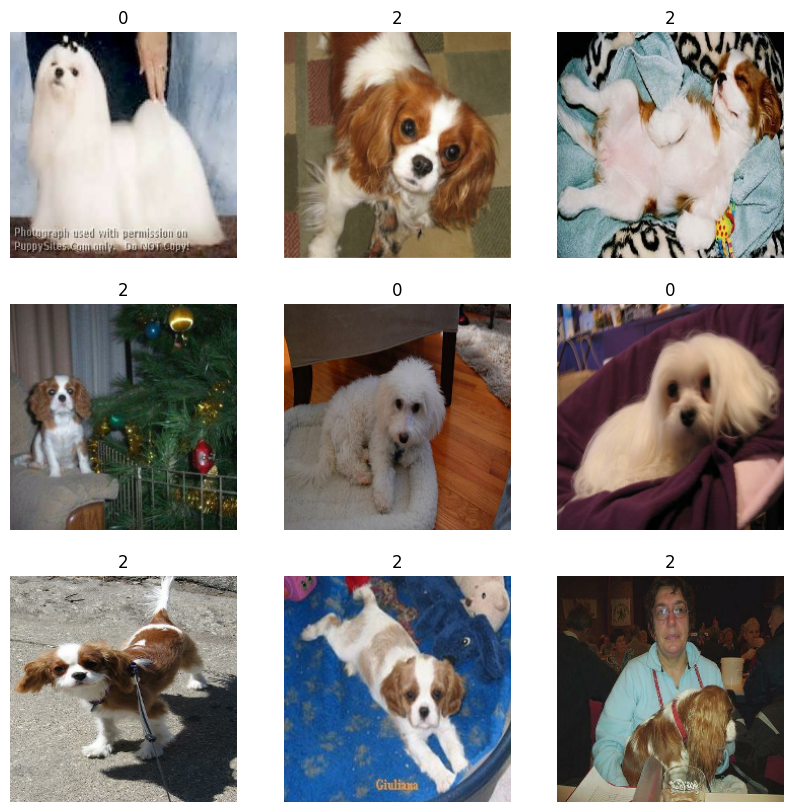

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 2. Preprocess Data

Standardizing the data

**data augmentation**

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

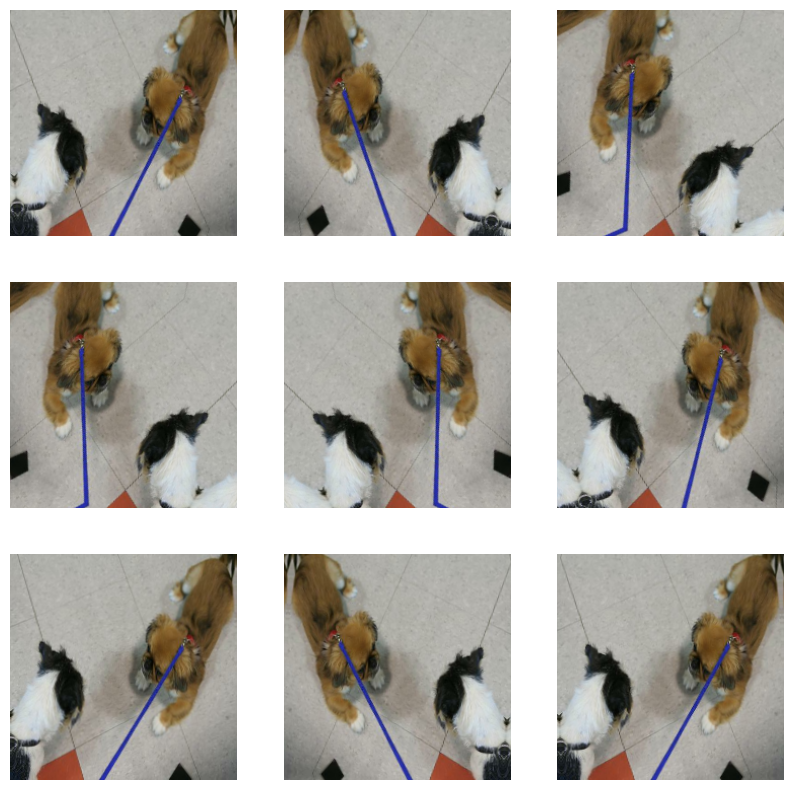

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [13]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# VGG16

VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

In [14]:
from keras.applications.vgg16 import VGG16


In [15]:
img_shape = (224,224,3) #les dimensions des images en entrée du réseau
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
base_model.trainable = False

In [18]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [19]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
class1 = Dense(1024, activation='relu')(x)

# Ajouter la nouvelle couche fully-connected pour la classification à X classes
output = Dense(1, activation='softmax')(class1)

In [20]:
new_model = Model(inputs=base_model.input, outputs=output)

In [21]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
new_model.compile(  loss='categorical_crossentropy', # classification binary, binary_crossentropy
  optimizer='adam',
  metrics=['accuracy'])

In [23]:
history = new_model.fit_generator(train_ds, epochs=5, validation_data=val_ds)

<ipython-input-23-5539da456bd4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 16s 226ms/step - loss: 0.0000e+00 - accuracy: 0.2521 - val_loss: 0.0000e+00 - val_accuracy: 0.2564
Epoch 2/5
30/30 [==============================] - 4s 125ms/step - loss: 0.0000e+00 - accuracy: 0.2521 - val_loss: 0.0000e+00 - val_accuracy: 0.2564
Epoch 3/5
30/30 [==============================] - 5s 166ms/step - loss: 0.0000e+00 - accuracy: 0.2521 - val_loss: 0.0000e+00 - val_accuracy: 0.2564
Epoch 4/5
30/30 [==============================] - 4s 124ms/step - loss: 0.0000e+00 - accuracy: 0.2521 - val_loss: 0.0000e+00 - val_accuracy: 0.2564
Epoch 5/5
30/30 [==============================] - 4s 125ms/step - loss: 0.0000e+00 - accuracy: 0.2521 - val_loss: 0.0000e+00 - val_accuracy: 0.2564


In [24]:
valid_loss, valid_accuracy = new_model.evaluate_generator(val_ds)

<ipython-input-24-ad49d9c4fdae>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = new_model.evaluate_generator(val_ds)


In [25]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.25641027092933655


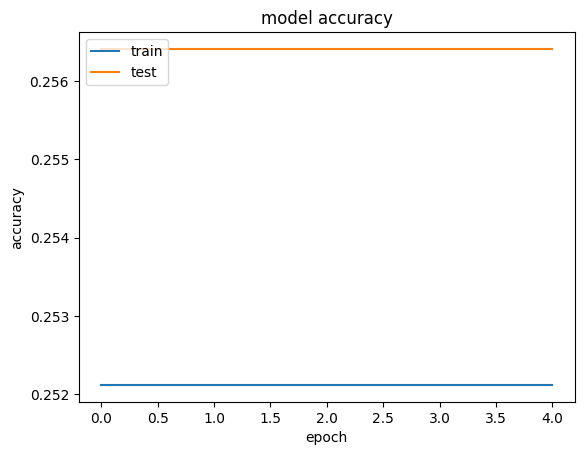

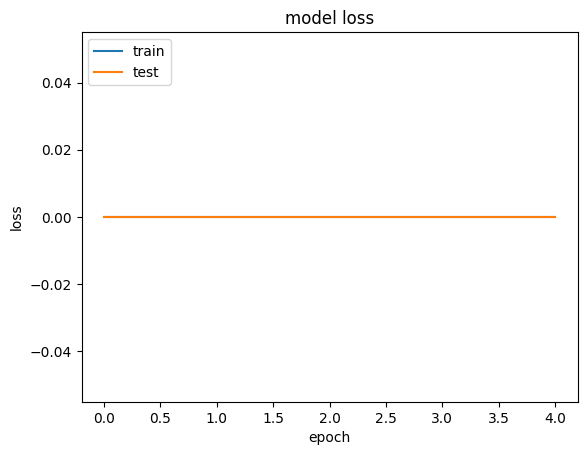

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# GridSearchCV

In [ ]:

param_grid = dict(epochs=[10,20,30])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit_generator(X, Y)

# CNN

Convolutional Neural Network
- Detercter les caracteristique d'une photo
-

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(64, (3,3), activation='relu',input_shape=(224,224,3),padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(3, activation='softmax'))

In [30]:
model.compile('adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 3)                

In [32]:
hist = model.fit_generator(train_ds, epochs=5, validation_data = val_ds )

Epoch 1/5


<ipython-input-32-cf247cd4cb39>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_ds, epochs=5, validation_data = val_ds )


ValueError: ignored

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('cat.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [ ]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [ ]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Strategie 1 : fine-tuning total

In [ ]:
for layer in model.layers:
   layer.trainable = True

Strategie 2 : extraction de features

In [ ]:
for layer in model.layers:
   layer.trainable = False

Strategie 3 : fine-tuning partiel

In [ ]:
# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
   layer.trainable = False

Enraînement du réseau

In [ ]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
